In [30]:
'''
Steps to get EDBOplus working:
1)Create and activate a conda environment
2)Download and navigate to the edbopaper directory in a terminal window (or Anaconda prompt window) and pip install -r requirements.txt
3)Put this .ipynb file in ANY directory (doesn't matter where it is).
4)Set the path to edbopaper in sys.path.append below
5)...
6)Profit.

'''

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


sys.path.append('/home/sanjay/AFRL/git_edbo/edbopaper')

In [3]:
from plus.optimizer_botorch import EDBOplus

In [4]:
#setting up reaction components
#np.arange creates a list of numbers from (start,stop,stepsize)
components = {
              'temperature':np.arange(30,140,3).tolist(),   # Discrete grid of concentrations
              'time': np.arange(1,45,2).tolist(),
              'stoichiometry': np.arange(0.33,0.66,0.025).tolist()}

In [5]:
#need to generage the data scope first
# scope = EDBOplus.generate_reaction_scope(components=components)

In [6]:
#Initialize EDBOplus class that will store predicted means, variances, etc.
bo = EDBOplus()

args = {'objectives': ['production_rate_(g/hr)','yield'], 'objective_mode': ['max','max'], 'batch': 3, 'seed': 42}


In [34]:
#Run this cell on scope data (csv file called reaction.csv)
bo.run(**args)

Using EHVI acquisition function.
Using hyperparameters optimized for continuous variables.
Using hyperparameters optimized for continuous variables.
Number of QMC samples: 128
Acquisition function optimized.
Predictions obtained and expected improvement obtained.


,temperature,time,stoichiometry,production_rate_(g/hr),yield,priority
318,135,41,0.630,PENDING,PENDING,1.0
926,129,41,0.655,PENDING,PENDING,1.0
2473,114,39,0.605,PENDING,PENDING,1.0
3,138,43,0.655,PENDING,PENDING,0.0
4,138,43,0.630,PENDING,PENDING,0.0
...,...,...,...,...,...,...
11391,78,23,0.480,3.5,65,-1.0
11392,54,41,0.580,0.6,41,-1.0
11393,54,41,0.480,3.4,66,-1.0
11394,45,29,0.605,0.4,35,-1.0


In [8]:
#Update reaction.csv with response values for highest priority samples (or update other priority reactions if you're a rebel and like to do what you want)

#Re-run the above cell to train the model and suggest next experiments 

In [35]:
df = pd.read_csv('reaction.csv')
df2 = pd.read_csv('pred_reaction.csv')



In [17]:
print(df.head(10))
print(df.tail(10))

   temperature  time  stoichiometry production_rate_(g/hr)    yield  priority
0          138    43          0.480                PENDING  PENDING       1.0
1          135    27          0.455                PENDING  PENDING       1.0
2          129    43          0.455                PENDING  PENDING       1.0
3          138    43          0.655                PENDING  PENDING       0.0
4          138    43          0.630                PENDING  PENDING       0.0
5          138    43          0.605                PENDING  PENDING       0.0
6          138    43          0.580                PENDING  PENDING       0.0
7          138    43          0.555                PENDING  PENDING       0.0
8          138    43          0.530                PENDING  PENDING       0.0
9          138    43          0.505                PENDING  PENDING       0.0
       temperature  time  stoichiometry production_rate_(g/hr) yield  priority
11386          117    35          0.630                    6.3 

In [18]:
print(df2.head())


   temperature  time  stoichiometry production_rate_(g/hr)    yield  priority  \
0          138    43          0.480                PENDING  PENDING       1.0   
1          135    27          0.455                PENDING  PENDING       1.0   
2          129    43          0.455                PENDING  PENDING       1.0   
3          138    43          0.655                PENDING  PENDING       0.0   
4          138    43          0.630                PENDING  PENDING       0.0   

   production_rate_(g/hr)_predicted_mean  \
0                               3.508489   
1                               3.041255   
2                               3.113267   
3                               4.924089   
4                               4.771966   

   production_rate_(g/hr)_predicted_variance  \
0                                   0.136435   
1                                   0.112414   
2                                   0.107296   
3                                   0.294268   
4       

In [19]:
print(df2.tail())

       temperature  time  stoichiometry production_rate_(g/hr) yield  \
11391           78    23          0.480                    3.5    65   
11392           54    41          0.580                    0.6    41   
11393           54    41          0.480                    3.4    66   
11394           45    29          0.605                    0.4    35   
11395           45     7          0.655                    0.2    21   

       priority  production_rate_(g/hr)_predicted_mean  \
11391      -1.0                               1.965807   
11392      -1.0                               1.894612   
11393      -1.0                               1.559669   
11394      -1.0                               1.513363   
11395      -1.0                               1.379298   

       production_rate_(g/hr)_predicted_variance  \
11391                                   0.190624   
11392                                   0.269559   
11393                                   0.316249   
11394     

In [36]:
df = df.replace('PENDING',pd.NaT)
df = df.dropna(axis=0)
df['production_rate_(g/hr)'] = df['production_rate_(g/hr)'].apply(pd.to_numeric)
df['yield'] = df['yield'].apply(pd.to_numeric)
results_length = []
for i in range(len(df['priority']==-1)):
    results_length.append(i)
print(results_length)
max_value_yield = df['yield'].max()
max_value_production_rate = df['production_rate_(g/hr)'].max()




# fig = px.scatter(df,x='yield', y='production_rate_(g/hr)',size='yield',color='yield',hover_data=['temperature','time','stoichiometry'])
# fig.show()
# print('Highest yield is {}%'.format(df['yield'].max()))
# print('Highest production rate is {}g/hr'.format(df['production_rate_(g/hr)'].max()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [24]:
#matplotlib plot
def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    
    '''Plotting process'''
    plt.scatter(Xs,Ys)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    plt.plot(pf_X, pf_Y, color='red')
    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    plt.show()

In [37]:
pareto_x = df['yield'].to_numpy()
pareto_y =df['production_rate_(g/hr)'].to_numpy()


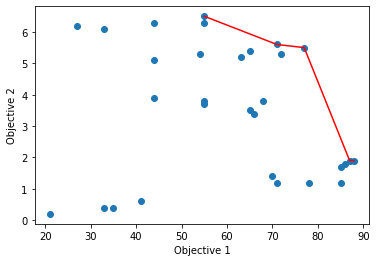

In [38]:


plot_pareto_frontier(pareto_x, pareto_y)

In [31]:
#for plotly

def plot_pareto_frontier2(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    
    '''Plotting process'''
    fig = px.scatter(x = Xs,y= Ys)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    fig.add_trace(go.Scatter(x=pf_X, y=pf_Y))
    fig2 = px.scatter(x = pf_X,y= pf_Y)
    fig.show()
    fig2.show()

In [39]:
plot_pareto_frontier2(pareto_x, pareto_y)